# Emotion-Recognition CK+ Model V18

## Note:

I will note include all the information about hardware and dataset, for reference check V1.

In [1]:
# Imports
import psutil as ps
import GPUtil as gpx
import platform
from tabulate import tabulate
from datetime import datetime
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Input, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

## Dataset


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# I will try tranfer learnin this time and see how it will perform
# The images I have in the Kaggle dataset are in grayscale, for MobileNet I have to convert them to RGB with three channels, what we do is just exand the channel we already have to 3 channels
def mobileNet_processed(img):
    # I first "convert" the image to RGB, by repeating the grayscale data x3 along the channel axis
    x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
    # Then I use the tf MobileNet preprocessing, which scales the pixel values in the image between -1 and 1, this function will return the preprocessed image data as a numpy array
    processedimage = tf.keras.applications.mobilenet.preprocess_input(mychannel)
    return processedimage

# This time I will perform more complex data augmentation
training_datagen = ImageDataGenerator(preprocessing_function=mobileNet_processed, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)
training_generator = training_datagen.flow_from_directory(
        '../../../datasets/CKplus_training_dataset/',
        target_size=(224,224),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )

validation_datagen = ImageDataGenerator(preprocessing_function=mobileNet_processed, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../../../datasets/CKplus_testing_dataset/',
        target_size=(224,224),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )

Num GPUs Available:  1
Found 265 images belonging to 7 classes.
Found 62 images belonging to 7 classes.


## Neural Network Model

I will add MobileNet and do some modification to some layers.

In [3]:
# I download the MobileNet model
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [4]:
# I grab the output from the sixth to last layer of the model and store it in this variable x

x = mobile.layers[-6].output

# Here I set the output layers by adding all the MobileNet layers we saved on x, and add a dense output layer having 7 nodes
output = Dense(units=7, activation='softmax')(x)

# Now, we construct the new fine-tuned model, which we're calling model.

model = Model(inputs=mobile.input, outputs=output)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## Training

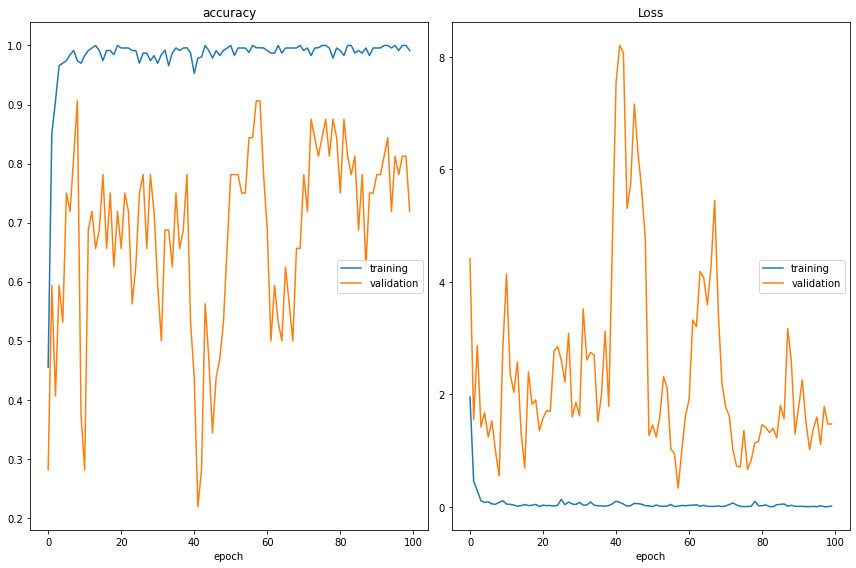

accuracy
	training         	 (min:    0.455, max:    1.000, cur:    0.991)
	validation       	 (min:    0.219, max:    0.906, cur:    0.719)
Loss
	training         	 (min:    0.001, max:    1.951, cur:    0.014)
	validation       	 (min:    0.332, max:    8.204, cur:    1.474)


In [5]:
# Set epochs and validation steps and steps per epoch
epochs = 100
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Optimizer [tweak for how much time training will take]
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
callbacks = [PlotLossesKerasTF()]

# Train the model
history = model.fit(
    x=training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Reuslts

Again the model has too many ups and down for the validation. Overfitting.

### Save the Model

In [6]:
# I save the model
model.save("ck_model_gen18.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("ck_model_gen18.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("ck_model_gen18.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [7]:
# Convert model to TensorFlowJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tensorflowJS')